# Clustering & sub-clustering example

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from matplotlib.colors import ListedColormap


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## 1.   Loading the Dataframe with pandas ->

In [97]:
pd.set_option("display.max.rows", 10)
pd.set_option("display.max.columns", 43)
missing_values = ["N/a", "na", np.nan] # Those are treated as 'NaN' as well

#? To get rid of the warning that shows up
dtype_dict = {
    '_id': int,
    'Area_of_Origin': str,
    'Building_Status': str,
    'Business_Impact': str,
    'Civilian_Casualties': float,
    'Count_of_Persons_Rescued': float,
    'Estimated_Dollar_Loss': float,
    'Estimated_Number_Of_Persons_Displaced': float,
    'Exposures': float,
    'Ext_agent_app_or_defer_time': str,
    'Extent_Of_Fire': str,
    'Final_Incident_Type': str,
    'Fire_Alarm_System_Impact_on_Evacuation': str,
    'Fire_Alarm_System_Operation': str,
    'Fire_Alarm_System_Presence': str,
    'Fire_Under_Control_Time': str,
    'Ignition_Source': str,
    'Incident_Number': str,
    'Incident_Station_Area': str,
    'Incident_Ward': float,
    'Initial_CAD_Event_Type': str,
    'Intersection': str,
    'Last_TFS_Unit_Clear_Time': str,
    'Latitude': float,
    'Level_Of_Origin': str,
    'Longitude': float,
    'Material_First_Ignited': str,
    'Method_Of_Fire_Control': str,
    'Number_of_responding_apparatus': float,
    'Number_of_responding_personnel': float,
    'Possible_Cause': str,
    'Property_Use': str,
    'Smoke_Alarm_at_Fire_Origin': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Failure': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Type': str,
    'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation': str,
    'Smoke_Spread': str,
    'Sprinkler_System_Operation': str,
    'Sprinkler_System_Presence': str,
    'Status_of_Fire_On_Arrival': str,
    'TFS_Alarm_Time': str,
    'TFS_Arrival_Time': str,
    'TFS_Firefighter_Casualties': float
}
###---
# url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/64a26694-01dc-4ec3-aa87-ad8509604f50/resource/1e824947-d73b-4f48-9bac-7f7f3731"
# df = pd.read_csv(url, dtype=dtype_dict, na_values = missing_values)
df = pd.read_csv("Fire Incidents Data.csv", dtype=dtype_dict, na_values=missing_values)

#? Size: 29425 rows × 43 columns

## 2. Pre-processing / Cleaning the Data ->

In [98]:
df.dropna(how="all", inplace=True)
df.drop_duplicates(keep="first", inplace=True)
#---

columns_to_drop = [
    'Area_of_Origin', 'Building_Status', 'Business_Impact', 'Extent_Of_Fire', 'Final_Incident_Type',
    'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence',
    'Ignition_Source', 'Incident_Station_Area', 'Initial_CAD_Event_Type', 'Intersection',
    'Level_Of_Origin', 'Material_First_Ignited', 'Method_Of_Fire_Control', 'Property_Use',
    'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
    'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', 'Smoke_Spread', 'Sprinkler_System_Operation',
    'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival'
]
df.drop(columns=columns_to_drop, inplace=True)
#---

# Drop all rows with missing latitude/longitude
df = df.dropna(subset=['Latitude', 'Longitude'])
df = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)]
#---

# Handle categorical columns
categorical_columns = ['Possible_Cause']

df = df[df['Possible_Cause'] != '99 - Undetermined']
#---

# Handling dates
datetime_columns = ['TFS_Alarm_Time', 'Fire_Under_Control_Time', 'TFS_Arrival_Time', 'Last_TFS_Unit_Clear_Time']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

## 2. Using the elbow method to find the optimal 'k' ->

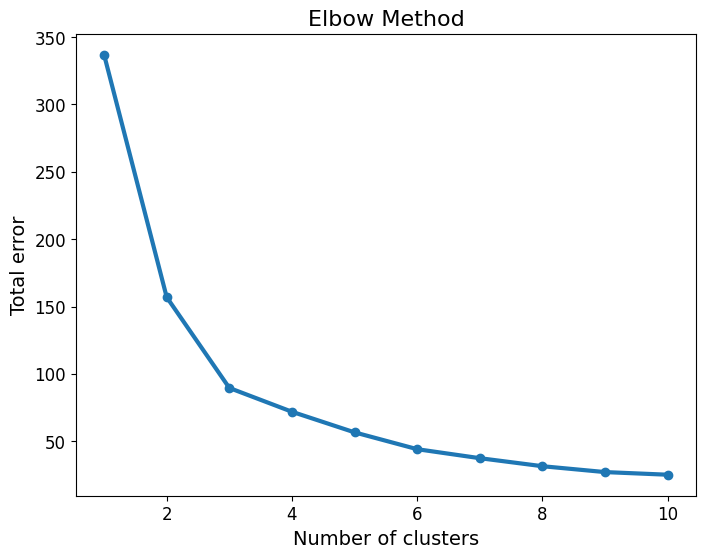

In [99]:
#? Calculate total error for different numbers of clusters with K-Means
err_total = []
n_clusters = 10
df_elbow = df[['Latitude', 'Longitude']]

for i in range(1, n_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_elbow)
    err_total.append(kmeans.inertia_)

# Plot elbow method
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1, n_clusters + 1), err_total, linewidth=3, marker='o')
ax.set_xlabel("Number of clusters", fontsize=14)
ax.set_ylabel("Total error", fontsize=14)
ax.set_title("Elbow Method", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- *Based on the Elbow method, I can see that the "elbow" is formed on the number 3 hence I am going to use k = 3.

## 3. Executing k-Means with `k = 3` ->

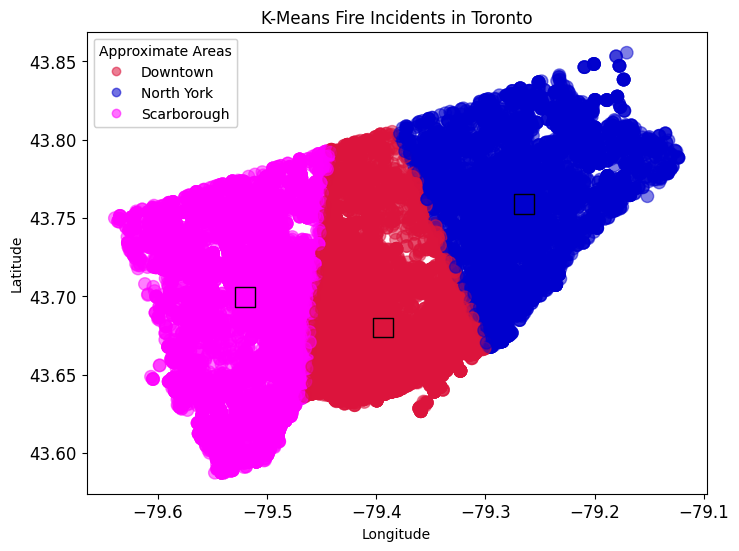

In [100]:
#? This Dataset contains Latitude values from [42 to 45] and Longitude from [-80 to -76] 
#? Based on google: 
# Downtown Toronto is approximate at: 43.6400 to 43.6544 Latitude / -79.3802 to -79.3802 Longtitude
# North York Toronto is approximate at: 43.65 to 43.80 Latitude / -79.40 to -79.30 Longtitude
# Scarborough Toronto is approximate at: 43.65 to 43.85 Latitude / -79.20 to -79.10 Longtitude
# So I will map each cluster with it's corresponding area name by creating another column

kmeans = KMeans(n_clusters=3, random_state=0)
df['Locations_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])
centroids = kmeans.cluster_centers_

# Map clusters to location names
cluster_labels = {
    0: 'Downtown',
    1: 'North York',
    2: 'Scarborough'
}
df['Location_Name'] = df['Locations_Cluster'].map(cluster_labels)
#---

# Plot clusters
fig, ax = plt.subplots(figsize=(8, 6))
customcmap = ListedColormap(["crimson", "mediumblue", "magenta"])
scatter = ax.scatter(df['Longitude'], df['Latitude'], c=df['Locations_Cluster'], cmap=customcmap, s=80, alpha=0.5)
ax.scatter(centroids[:, 1], centroids[:, 0], marker='s', s=200, c=[0, 1, 2], cmap=customcmap, edgecolor='black')
ax.set_title('K-Means Fire Incidents in Toronto')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
handles, _ = scatter.legend_elements()
labels = [cluster_labels[i] for i in range(3)]
legend1 = ax.legend(handles, labels, title="Approximate Areas")
ax.add_artist(legend1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## 4. Creating 3 Sub-Dataframes based on each location (Clusters) ->

In [101]:
downtown_df = df[df['Location_Name'] == 'Downtown']
north_york_df = df[df['Location_Name'] == 'North York']
scarborough_df = df[df['Location_Name'] == 'Scarborough']

## 5. Sub Clustering 

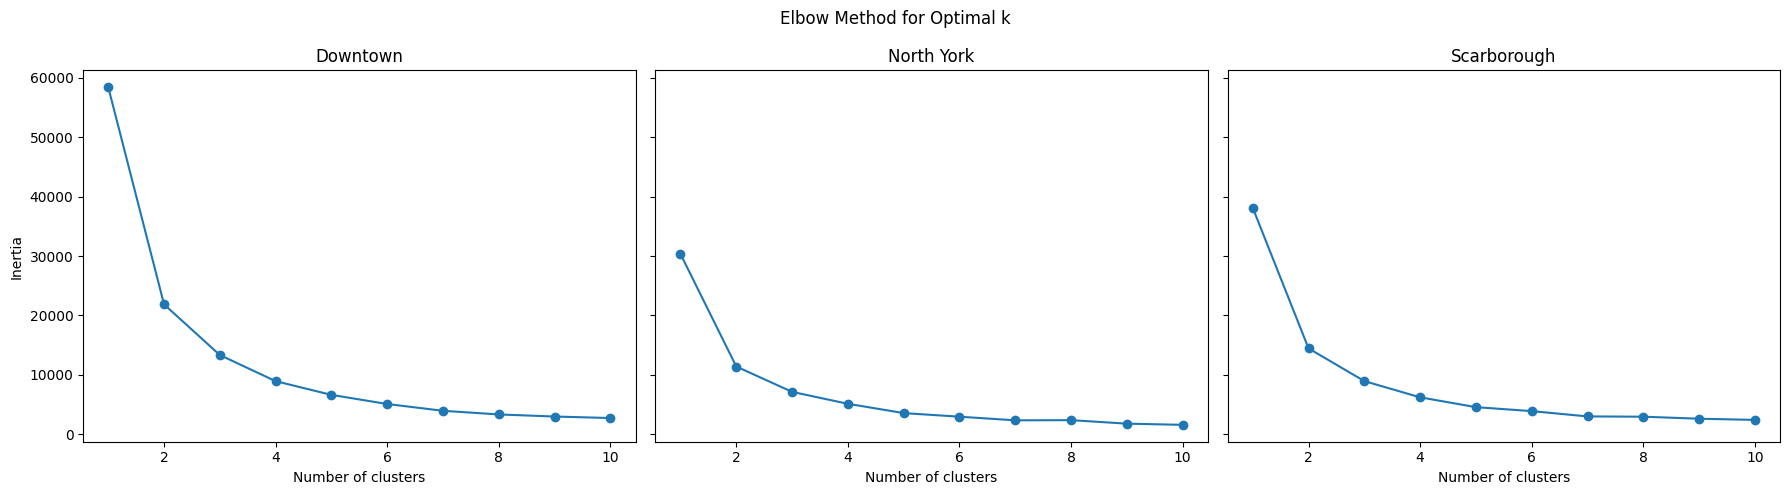

In [102]:
datetime_columns = ['TFS_Alarm_Time', 'Fire_Under_Control_Time', 'TFS_Arrival_Time', 'Last_TFS_Unit_Clear_Time']
cause_column = 'Possible_Cause'

def calculate_inertia(data, datetime_columns, cause_column, max_clusters=10):
    data = data.copy()
    
    # Find the earliest time in the dataset
    reference_time = pd.Timestamp('1970-01-01')
    
    # Convert datetime columns to numeric representation in hours
    for col in datetime_columns:
        earliest_time = data[col].min()
        data.loc[:, col + '_numeric'] = (data[col] - earliest_time) / pd.Timedelta(hours=1)
    
    # Encode the possible cause column efficiently
    le = LabelEncoder()
    data.loc[:, cause_column + '_encoded'] = le.fit_transform(data[cause_column].astype(str))
    
    # Combine all features for clustering
    feature_columns = [col + '_numeric' for col in datetime_columns] + [cause_column + '_encoded']
    
    # Handle missing values in feature columns
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data[feature_columns])
    
    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_imputed)
    
    # Calculate inertia for different number of clusters
    inertia_values = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data_scaled)
        inertia_values.append(kmeans.inertia_)
    
    return inertia_values

# Calculate inertia for downtown_df
inertia_downtown = calculate_inertia(downtown_df, datetime_columns, cause_column)

# Calculate inertia for north_york_df
inertia_north_york = calculate_inertia(north_york_df, datetime_columns, cause_column)

# Calculate inertia for scarborough_df
inertia_scarborough = calculate_inertia(scarborough_df, datetime_columns, cause_column)

# Plotting the elbow curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Elbow Method for Optimal k')

axes[0].plot(range(1, len(inertia_downtown) + 1), inertia_downtown, marker='o')
axes[0].set_title('Downtown')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Inertia')

axes[1].plot(range(1, len(inertia_north_york) + 1), inertia_north_york, marker='o')
axes[1].set_title('North York')
axes[1].set_xlabel('Number of clusters')

axes[2].plot(range(1, len(inertia_scarborough) + 1), inertia_scarborough, marker='o')
axes[2].set_title('Scarborough')
axes[2].set_xlabel('Number of clusters')

plt.tight_layout()
plt.show()

In [103]:
def perform_kmeans_clustering(data, datetime_columns, cause_column, k):
    
    # Find the earliest time in the dataset
    reference_time = pd.Timestamp('1970-01-01')
    
    for col in datetime_columns:
        earliest_time = data[col].min()
        # Convert to duration since the earliest time in hours
        data[col + '_numeric'] = (data[col] - earliest_time) / pd.Timedelta(hours=1)
    
    # Encode the possible cause column
    le = LabelEncoder()
    data[cause_column + '_encoded'] = le.fit_transform(data[cause_column])
    
    # Combine all features for clustering
    feature_columns = [col + '_numeric' for col in datetime_columns] + [cause_column + '_encoded']
    
    # Handle missing values in feature columns
    imputer = SimpleImputer(strategy='median')
    data_imputed = imputer.fit_transform(data[feature_columns])
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    data['Cluster'] = kmeans.fit_predict(data_imputed)
    
    return data, kmeans.cluster_centers_


# Perform KMeans clustering on each dataset
downtown_df, downtown_centers = perform_kmeans_clustering(downtown_df, datetime_columns, cause_column, 3)
north_york_df, north_york_centers = perform_kmeans_clustering(north_york_df, datetime_columns, cause_column, 3)
scarborough_df, scarborough_centers = perform_kmeans_clustering(scarborough_df, datetime_columns, cause_column, 3)



/tmp/ipykernel_8776/901567074.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_numeric'] = (data[col] - earliest_time) / pd.Timedelta(hours=1)
/tmp/ipykernel_8776/901567074.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_numeric'] = (data[col] - earliest_time) / pd.Timedelta(hours=1)
/tmp/ipykernel_8776/901567074.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

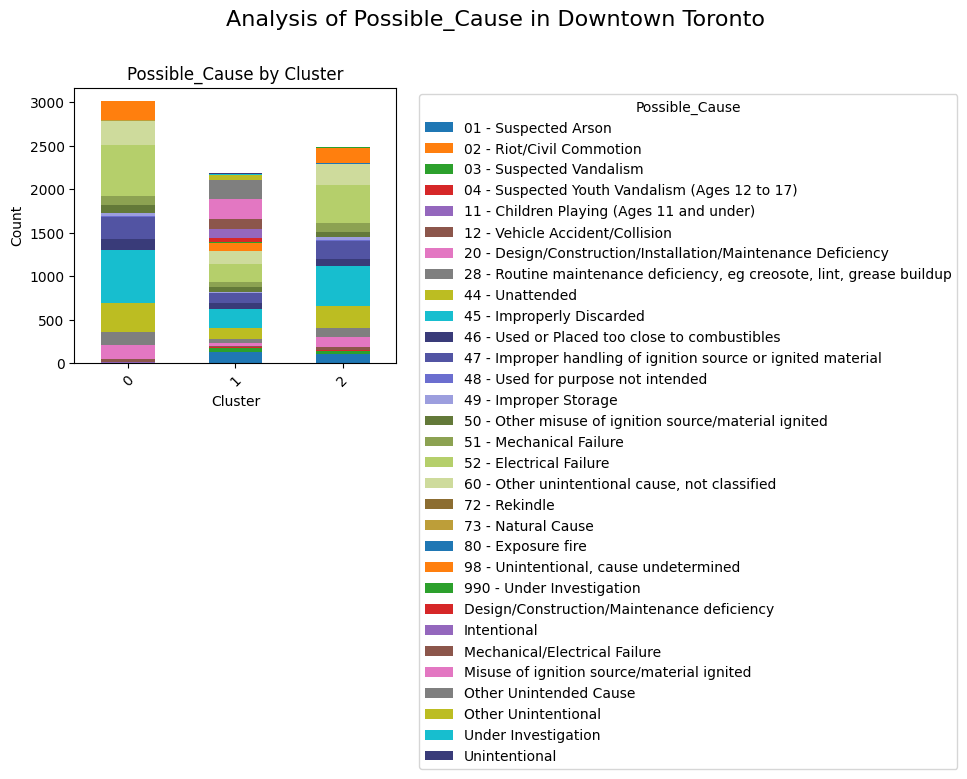

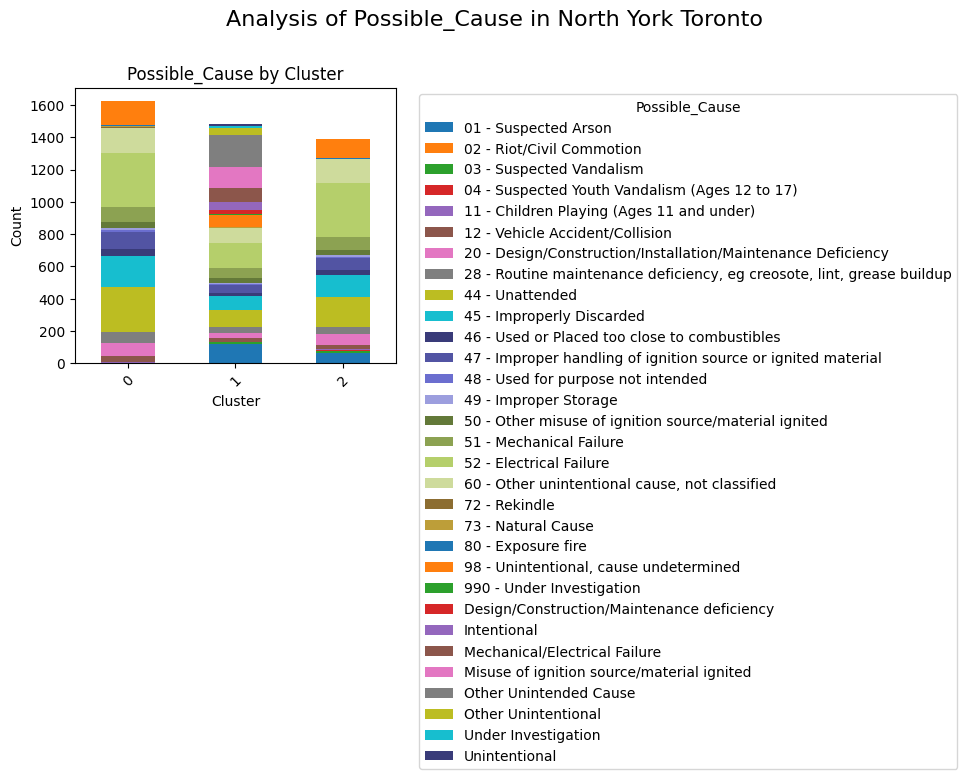

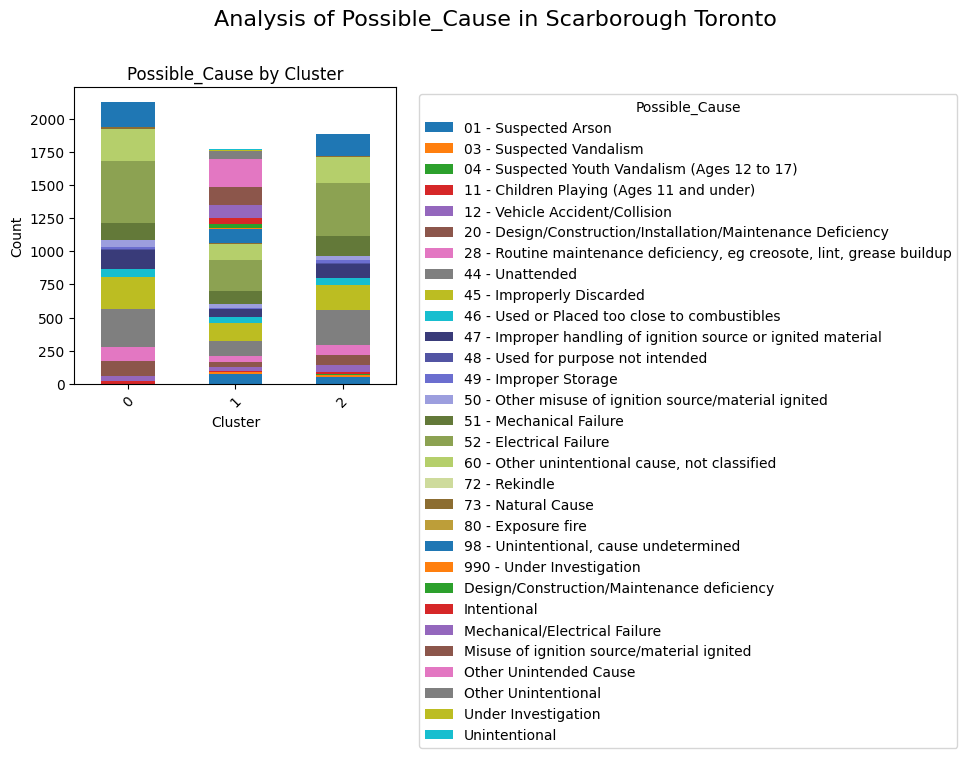

In [104]:
def plot_cause_analysis(df, location_name, cause_column):
    # Example of specifying colors manually
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
        '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939',
        '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle(f'Analysis of {cause_column} in {location_name}', fontsize=16)

    cause_counts = df.groupby('Cluster')[cause_column].value_counts().unstack().fillna(0)
    cause_counts.plot(kind='bar', stacked=True, ax=ax, color=colors)
    
    ax.set_title(f'{cause_column} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend(title=cause_column, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_cause_analysis(downtown_df, 'Downtown Toronto', cause_column)
plot_cause_analysis(north_york_df, 'North York Toronto', cause_column)
plot_cause_analysis(scarborough_df, 'Scarborough Toronto', cause_column)


/tmp/ipykernel_8776/1407980620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Response_Time'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']).dt.total_seconds() / 3600
/tmp/ipykernel_8776/1407980620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fire_Under_Control_Time'] = (df['Fire_Under_Control_Time'] - df['TFS_Arrival_Time']).dt.total_seconds() / 3600
/tmp/ipykernel_8776/1407980620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

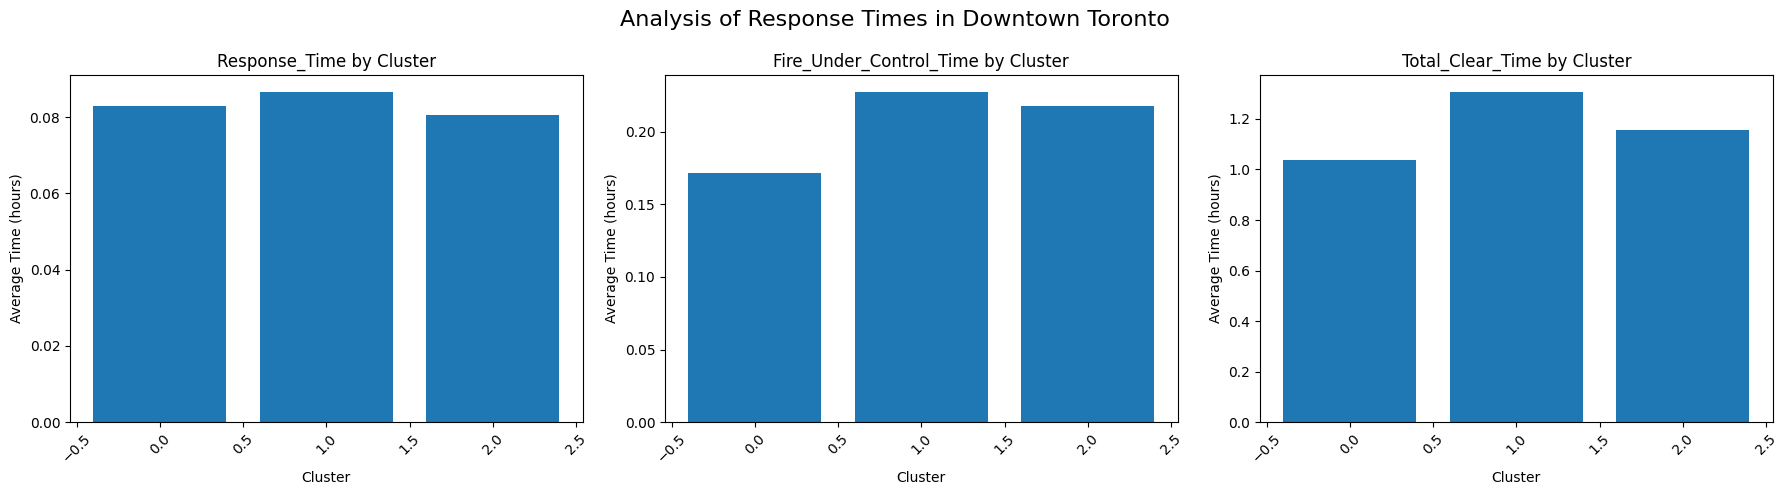

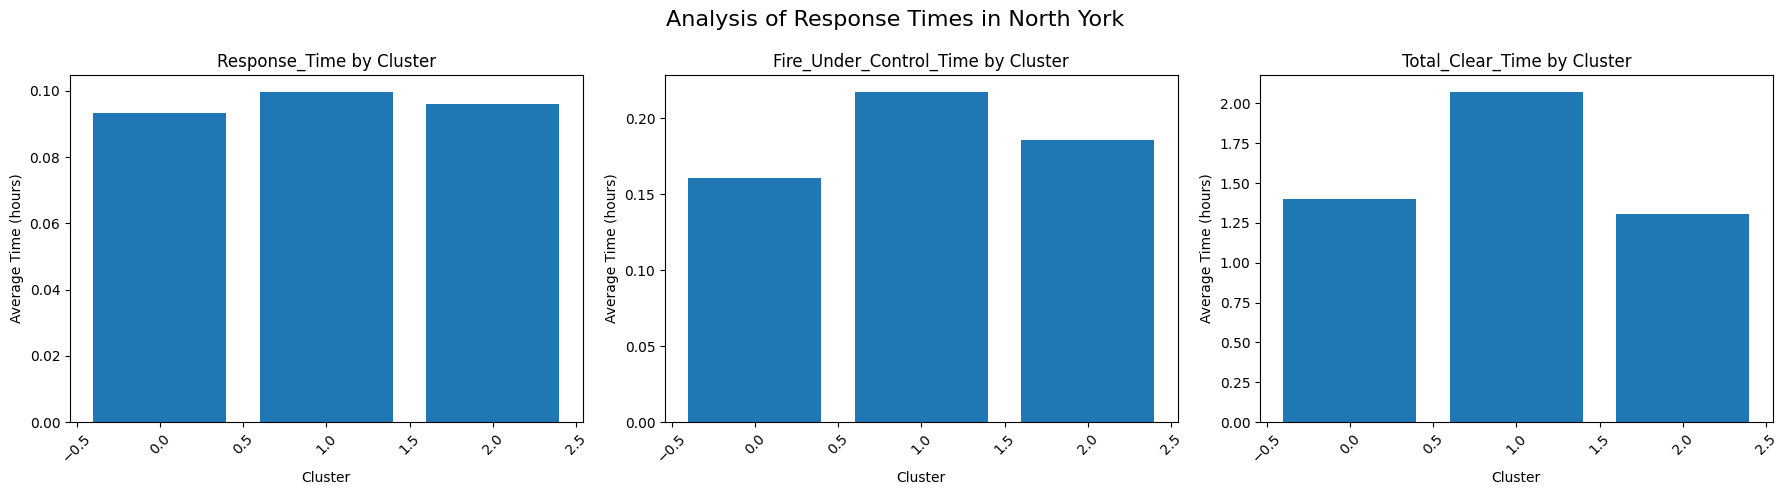

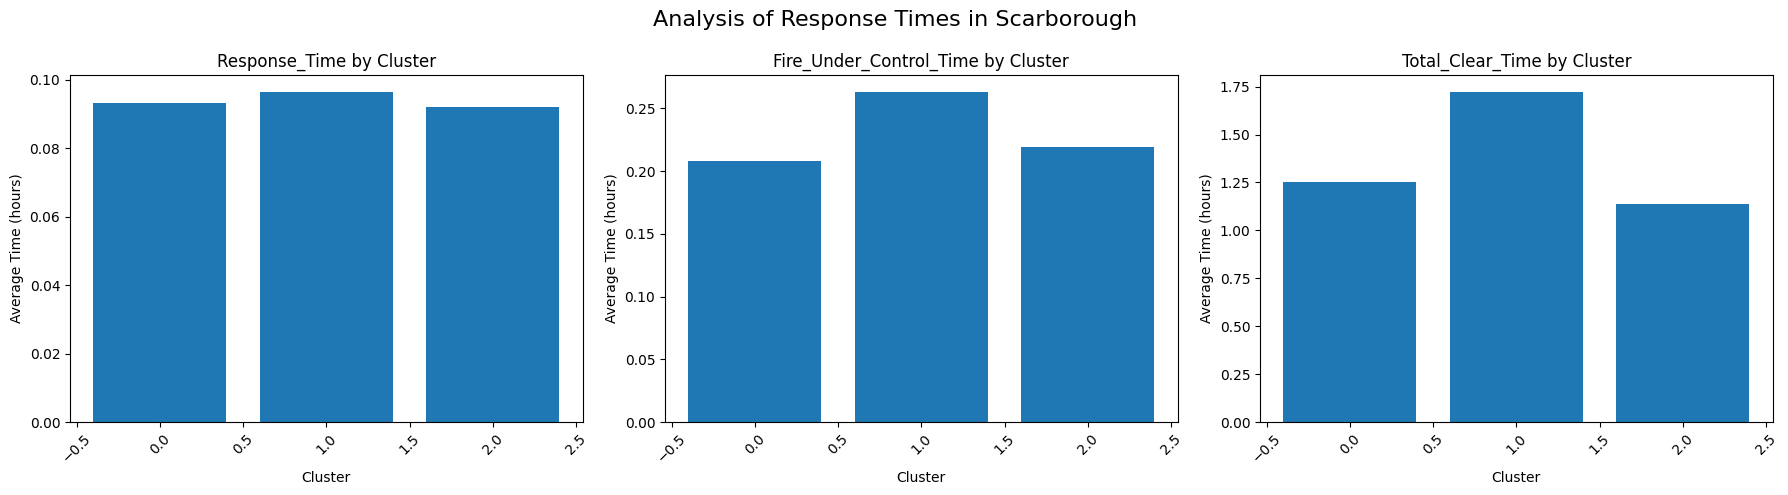

In [105]:
# Calculate response metrics
def calculate_response_metrics(df):
    df['Response_Time'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']).dt.total_seconds() / 3600
    df['Fire_Under_Control_Time'] = (df['Fire_Under_Control_Time'] - df['TFS_Arrival_Time']).dt.total_seconds() / 3600
    df['Total_Clear_Time'] = (df['Last_TFS_Unit_Clear_Time'] - df['TFS_Arrival_Time']).dt.total_seconds() / 3600
    return df

downtown_df = calculate_response_metrics(downtown_df)
north_york_df = calculate_response_metrics(north_york_df)
scarborough_df = calculate_response_metrics(scarborough_df)
#---

def plot_response_time_analysis(df, location_name):
    metrics = ['Response_Time', 'Fire_Under_Control_Time', 'Total_Clear_Time']
    fig, axs = plt.subplots(1, len(metrics), figsize=(18, 5))
    fig.suptitle(f'Analysis of Response Times in {location_name}', fontsize=16)

    for i, metric in enumerate(metrics):
        avg_time = df.groupby('Cluster')[metric].mean()
        ax = axs[i]
        ax.bar(avg_time.index, avg_time.values)
        ax.set_title(f'{metric} by Cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Average Time (hours)')
        ax.tick_params(axis='x', labelrotation=45)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Plot the response time analysis for each sub-dataframe
plot_response_time_analysis(downtown_df, 'Downtown Toronto')
plot_response_time_analysis(north_york_df, 'North York')
plot_response_time_analysis(scarborough_df, 'Scarborough')

  Cluster Response_Time           Fire_Under_Control_Time            \
                   mean       std                    mean       std   
0       0      0.083014  0.206952                0.171671  0.347722   
1       1      0.086695  0.036283                0.227603  0.640420   
2       2      0.080528  0.028422                0.217873  0.474796   
3       0      0.093284  0.028872                0.160319  0.304517   
4       1      0.099799  0.041048                0.217460  0.364750   
5       2      0.095971  0.114379                0.185621  0.321871   
6       0      0.093095  0.029213                0.207762  0.559534   
7       1      0.096572  0.034402                0.263479  0.756559   
8       2      0.092050  0.032307                0.219216  0.793530   

  Total_Clear_Time                    Location  
              mean       std                    
0         1.037478  1.813030  Downtown Toronto  
1         1.308608  3.776059  Downtown Toronto  
2         1.157051  2.

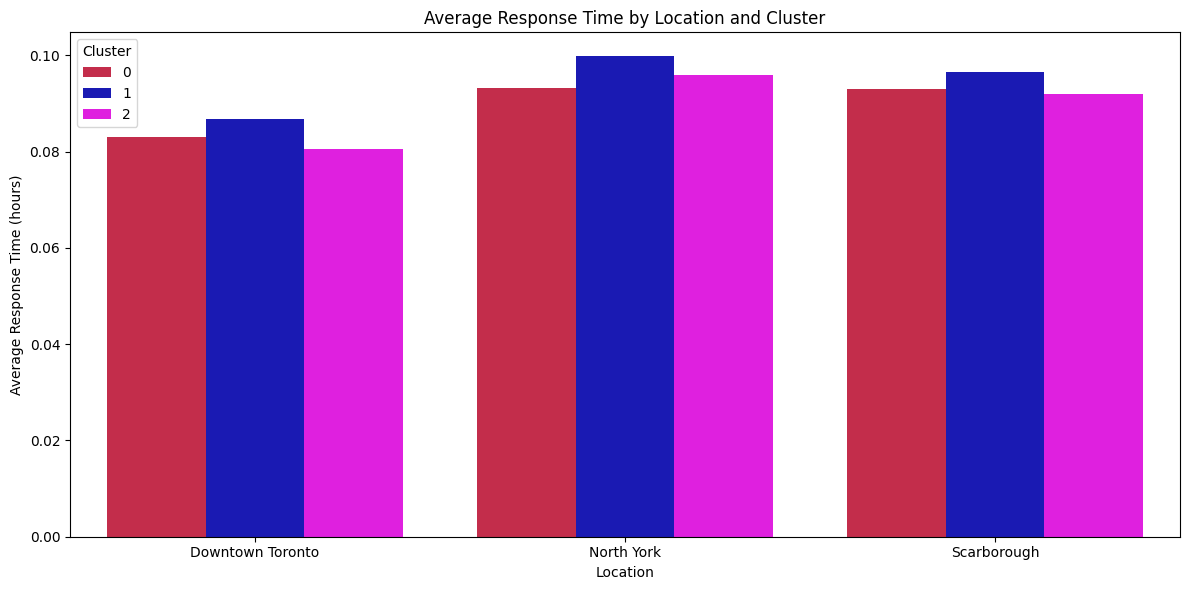

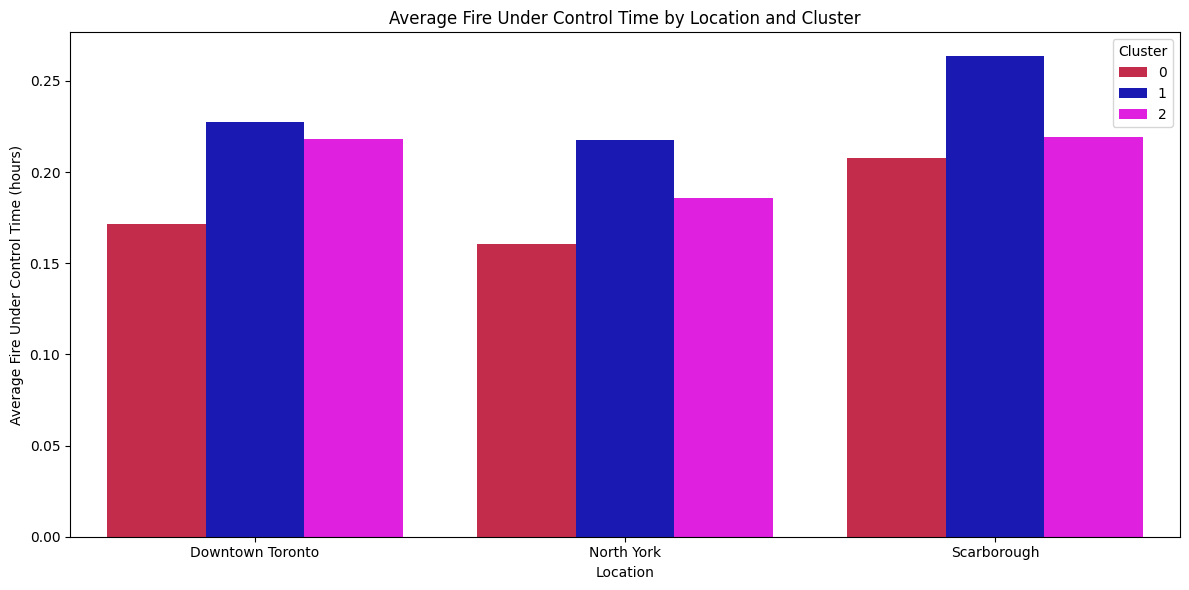

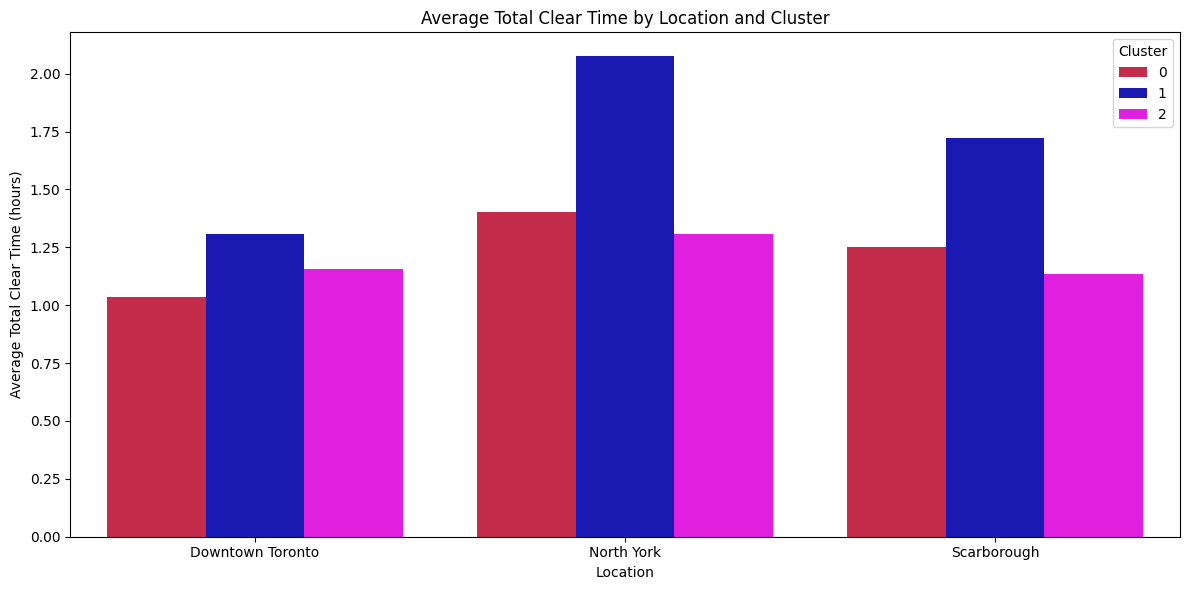

In [106]:
# Each row in downtown_stats corresponds to one cluster identified 
# in the downtown_df DataFrame. Since downtown_df was clustered into 
# 3 distinct groups (clusters), downtown_stats will have 3 rows—one for each cluster.

def calculate_summary_statistics(df, location_name):
    metrics = ['Response_Time', 'Fire_Under_Control_Time', 'Total_Clear_Time']
    summary_stats = df.groupby('Cluster')[metrics].agg(['mean', 'std']).reset_index()
    summary_stats['Location'] = location_name
    return summary_stats

downtown_stats = calculate_summary_statistics(downtown_df, 'Downtown Toronto')
north_york_stats = calculate_summary_statistics(north_york_df, 'North York')
scarborough_stats = calculate_summary_statistics(scarborough_df, 'Scarborough')

all_stats = pd.concat([downtown_stats, north_york_stats, scarborough_stats], ignore_index=True)
print(all_stats)


def plot_summary_statistics(stats, metric):
    customcmap = ListedColormap(["crimson", "mediumblue", "magenta"])
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=stats, x='Location', y=(metric, 'mean'), hue='Cluster', ax=ax, palette=customcmap.colors)
    ax.set_title(f'Average {metric.replace("_", " ")} by Location and Cluster')
    ax.set_xlabel('Location')
    ax.set_ylabel(f'Average {metric.replace("_", " ")} (hours)')
    ax.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

# Plotting for each metric
plot_summary_statistics(all_stats, 'Response_Time')
plot_summary_statistics(all_stats, 'Fire_Under_Control_Time')
plot_summary_statistics(all_stats, 'Total_Clear_Time')

Sample analysis on the Possible cause (No clustering yet) -> 

NaN values in y_train: 3314
NaN values in y_test: 1444
The mean safety score for Downtown is 24140.58
NaN values in y_train: 1439
NaN values in y_test: 648
The mean safety score for North York is 28537.99
NaN values in y_train: 1702
NaN values in y_test: 716
The mean safety score for Scarborough is 39668.99


/tmp/ipykernel_8776/8701264.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(location_means.keys()), y=list(location_means.values()), ax=ax, palette='viridis')


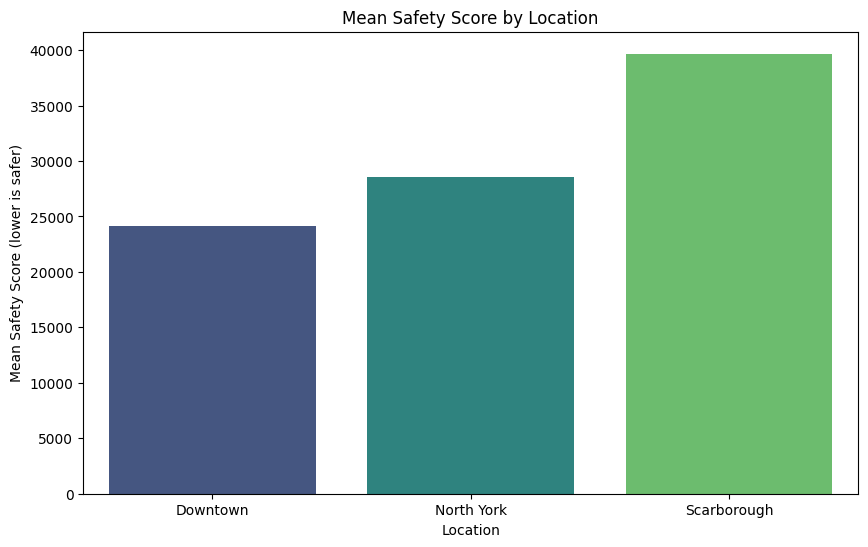

In [107]:
categorical_columns = ['Possible_Cause']  # Adjust according to your actual categorical columns

# Calculate safety score for each sub-dataframe (if not already calculated)
for df in [downtown_df, north_york_df, scarborough_df]:
    df['Safety_Score'] = df['Response_Time'] + df['Fire_Under_Control_Time'] + df['Total_Clear_Time'] + df['Civilian_Casualties'] + df['Estimated_Dollar_Loss']

# Feature columns for prediction
feature_columns = ['Response_Time', 'Fire_Under_Control_Time', 'Total_Clear_Time', 'Civilian_Casualties', 'Estimated_Dollar_Loss'] + categorical_columns

# Dictionary to store results for each location
location_means = {}

# Iterate over each location DataFrame
for location_df, location_name in zip([downtown_df, north_york_df, scarborough_df], ['Downtown', 'North York', 'Scarborough']):
    
    # Encode categorical features
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        location_df[col] = le.fit_transform(location_df[col].astype(str))
        label_encoders[col] = le
    
    X = location_df[feature_columns]
    y = location_df['Safety_Score']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Check for NaN values in y_train and y_test before fitting the model
    print("NaN values in y_train:", y_train.isnull().sum())
    print("NaN values in y_test:", y_test.isnull().sum())

    # Drop rows with NaN values in y_train and corresponding rows in X_train
    train_na_mask = y_train.notna()  # Keep only non-NaN values
    X_train = X_train[train_na_mask]
    y_train = y_train[train_na_mask]

    # Drop rows with NaN values in y_test and corresponding rows in X_test
    test_na_mask = y_test.notna()  # Keep only non-NaN values
    X_test = X_test[test_na_mask]
    y_test = y_test[test_na_mask]

    # Train a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf.predict(X_test)

    # Train a Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    
    # Calculate mean safety score
    mean_safety_score = location_df['Safety_Score'].mean()
    location_means[location_name] = mean_safety_score
    
    # Print mean safety score for current location
    print(f"The mean safety score for {location_name} is {mean_safety_score:.2f}")


# Display mean safety scores for each location
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=list(location_means.keys()), y=list(location_means.values()), ax=ax, palette='viridis')
ax.set_title('Mean Safety Score by Location')
ax.set_xlabel('Location')
ax.set_ylabel('Mean Safety Score (lower is safer)')
plt.show()